# Credit Card Fraud Detection

### Executive Summary
In this project, we will analyze the dataset which contains 492 frauds out of 284,807 transactions from Kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud). The transactions were made by european credit card holders in September 2013. Our objective of this project is to fit the dataset into our machine learning models to predict precisely while dealing with the highly unbalanced issue of this dataset. Since there are 28 variables which are the result of a principle component analysis (PCA) transformation and the information of the variables was not given, we will drop the variables which have similar distributions. Our next step is to deal with the unbalanced issue. We will use the synthetic minority over-sampling technique (SMOTE) to resample the dataset to make the numbers of frauds and normal transactions even. The last step is to compare the machine learning methods and we found that Xgboost returned the highest AUC score.

### Variable Description
<ul>
<li><b>Time</b>: The seconds elapsed between each transaction and the first transaction in the dataset
<li><b>V1 to V28</b>: Principle components
<li><b>Amount</b>: Transaction amount in Euro
<li><b>Class</b>: The actual classfication classes (0 = Normal transaction, 1 = Fraud)

### Exploratory Data Analysis (EDA)
In this section, we found that the number of frauds only accounts for 0.17% of all the transaction, so in order to run the machine learning algorithm, we will need to resample the data to make the number of frauds and normal transactions even. We also found that the greatest amount of normal transactions is around 25,000 euro, while the greatest amount of fraud is around 2000 euro.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%pylab inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score ,auc, roc_curve
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, neural_network
from imblearn.over_sampling import SMOTE
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
print 'The number of normal transactions : ' + str(sum(df.Class == 0))
print 'The number of frauds : ' + str(sum(df.Class == 1))
print 'The percentage of fraud of all transactions : ' + str(float(sum(df.Class == 1))/float(len(df.Class))*100.0)

The number of normal transactions : 284315
The number of frauds : 492
The percentage of fraud of all transactions : 0.172748563062


In [5]:
pd.value_counts(df['Class'])

0    284315
1       492
Name: Class, dtype: int64

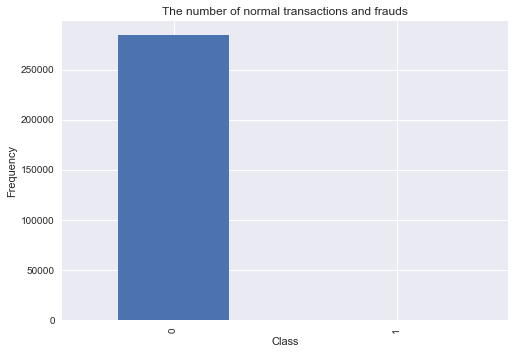

In [6]:
pd.value_counts(df['Class'], sort=True).plot(kind='bar')
plt.title('The number of normal transactions and frauds')
plt.xlabel('Class')
plt.ylabel('Frequency')

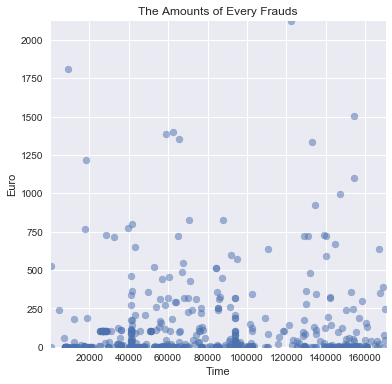

In [7]:
figure(figsize=(6,6))
plt.scatter(df['Time'][df.Class==1], df['Amount'][df.Class==1], alpha=0.5)
plt.margins(0)
plt.title('The Amounts of Every Frauds')
plt.xlabel('Time')
plt.ylabel('Euro')

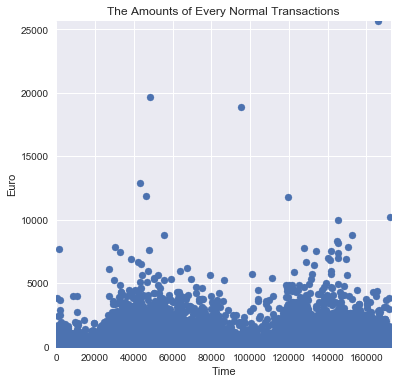

In [8]:
figure(figsize=(6,6))
plt.scatter(df['Time'][df.Class==0], df['Amount'][df.Class==0])
plt.margins(0)
plt.title('The Amounts of Every Normal Transactions')
plt.xlabel('Time')
plt.ylabel('Euro')

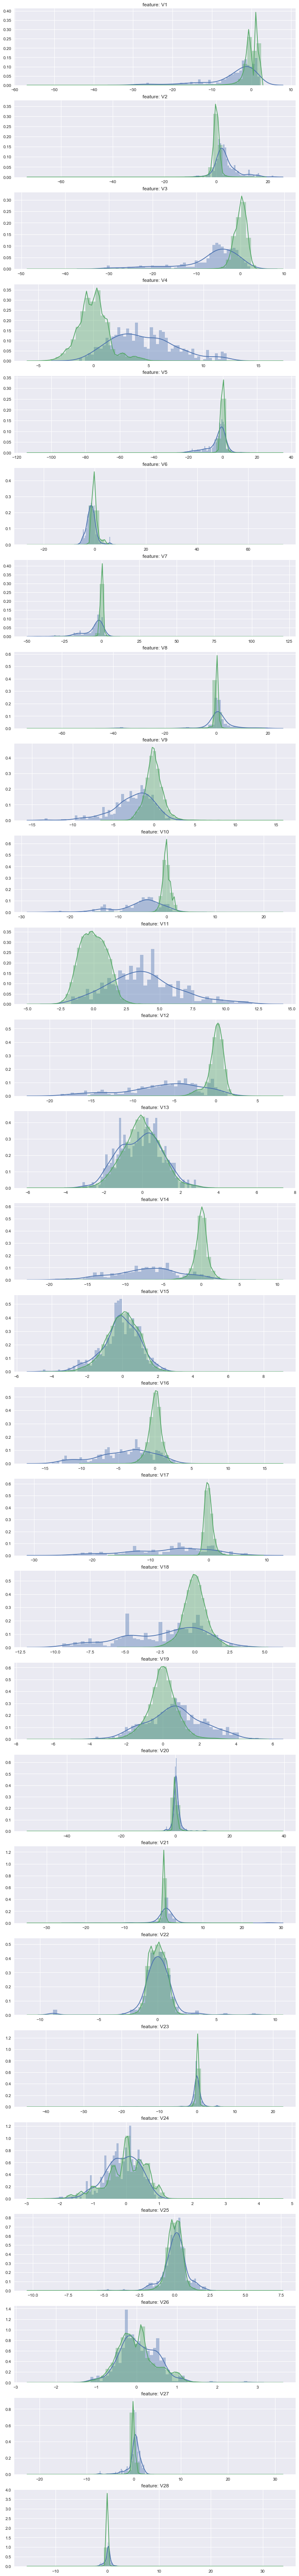

In [9]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[df.iloc[:, 1:29].columns]):
   ax = plt.subplot(gs[i])
   sns.distplot(df[cn][df.Class == 1], bins=50)
   sns.distplot(df[cn][df.Class == 0], bins=50)
   ax.set_xlabel('')
   ax.set_title('feature: ' + str(cn))
plt.show()

### Cleaning
This dataset is very clean and doesn't contain any NAs, so the cleaning we did in this section is to drop some variables which distribute similarly, normalize the Amount variable which is the only variable that has not been normalized yet, and resampling the whole dataset.

In [10]:
df = df.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)

#### Normalizing the Amount variable

In [11]:
df['Amount_Stand'] = StandardScaler().fit_transform(df['Amount'].reshape(-1, 1))
df = df.drop(['Time', 'Amount'], axis=1)
df.head()

/Users/ireneliu/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Class,Amount_Stand
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,0,-0.073403


#### Resampling

In [12]:
X = df.drop('Class', axis=1)
y = df.Class

In [13]:
X_resample, y_resample = SMOTE().fit_sample(X, y)
print 'The number of transactions after resampling : ' + str(len(X_resample))
print 'If the number of frauds is equal to the number of normal tansactions? ' + str(sum(y_resample == 0) == sum(y_resample == 1))

The number of transactions after resampling : 568630
If the number of frauds is equal to the number of normal tansactions? True


### Machine Learning
We will apply 7 machine learning algorithms for classification in this section. Since we have already resampled the dataset, the area under the ROC curve will be used to evaluate which algorithm performs the best. Our result shows that the Xgboost returned the greatest AUC value.
<ul>
<li><b>Algorithms</b>: Logistic regression, Naive Bayes, Decision tree, Random forest, Quadratic discriminant analysis, Neural network (MLP), Xgboost

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=3)

In [15]:
MLA = [
    linear_model.LogisticRegressionCV(),
    naive_bayes.GaussianNB(),
    tree.DecisionTreeClassifier(max_depth=3),
    ensemble.RandomForestClassifier(max_depth=3, n_estimators=10, max_features=1),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    neural_network.MLPClassifier(alpha=1)
]

In [16]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for alg in MLA:
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'Precision'] = precision_score(y_test, predicted)
    MLA_compare.loc[row_index, 'AUC'] = auc(fp, tp)
    
    row_index+=1
MLA_compare.sort_values(by = ['AUC'], ascending = False, inplace = True)
MLA_compare

,MLA Name,Precision,AUC
5,MLPClassifier,0.985920,0.962262
0,LogisticRegressionCV,0.971735,0.937413
2,DecisionTreeClassifier,0.956165,0.936516
3,RandomForestClassifier,0.988068,0.930280
4,QuadraticDiscriminantAnalysis,0.965309,0.925114
1,GaussianNB,0.979399,0.916958


In [17]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [18]:
clf = xgb.XGBClassifier(n_estimators=500, objective='binary:logistic', eval_metric='auc', eta=0.1, max_depth=6, subsample=1, colsample_bytree=0.3, silent=1)
clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.97876
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.982434
[2]	validation_0-auc:0.986753
[3]	validation_0-auc:0.989352
[4]	validation_0-auc:0.989767
[5]	validation_0-auc:0.990943
[6]	validation_0-auc:0.991514
[7]	validation_0-auc:0.992005
[8]	validation_0-auc:0.993375
[9]	validation_0-auc:0.994347
[10]	validation_0-auc:0.99439
[11]	validation_0-auc:0.994717
[12]	validation_0-auc:0.995206
[13]	validation_0-auc:0.995523
[14]	validation_0-auc:0.995619
[15]	validation_0-auc:0.995684
[16]	validation_0-auc:0.995945
[17]	validation_0-auc:0.996055
[18]	validation_0-auc:0.996392
[19]	validation_0-auc:0.996693
[20]	validation_0-auc:0.996763
[21]	validation_0-auc:0.996913
[22]	validation_0-auc:0.997032
[23]	validation_0-auc:0.997167
[24]	validation_0-auc:0.997226
[25]	validation_0-auc:0.997263
[26]	validation_0-auc:0.997427
[27]	validation_0-auc:0.997597
[28]	validation_0-auc:0.997744
[29]	validation_0-auc:0.997819
[30]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, eta=0.1, eval_metric='auc', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=1)